In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models
from torchsummary import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import time
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

    
def plot_samples_on_epoch(samples, nrow=4, chanels=3, size=(12,12)):
    grid_img = torchvision.utils.make_grid(samples, nrow=nrow)
    if chanels==1:
        see_plot(grid_img.permute(1, 2, 0)*255, size=size)
    else:
        see_plot(grid_img.permute(1, 2, 0), size=size)
        
def see_plot(pict, size=(6,6)):
    plt.figure(figsize=size)
    plt.imshow(pict,cmap='gray') #, cmap=color, color='gray'
    plt.grid()
    plt.show()

def load_image(video, frame):
    path = '/media/laggg/surviv_rl_data/all_videoframes_rgb_96/{}/'.format(video)
    p = cv2.imread(path + 'f_{}.jpg'.format(frame))
    return p[:,:,::-1]
#----------------------------------------------------------------------------------------------------
        
# info
print('torch_version: {},\ntorchvision_version: {}'.format(torch.__version__,torchvision.__version__))
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('device:', device)

torch_version: 1.8.1+cu102,
torchvision_version: 0.8.1
device: cuda:0


In [2]:
#-----------------------------------------------------------------------------------------
import itertools
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
%matplotlib inline

def plot_confusion_matrix(targets,predictions,classes,
                          normalize=True,title='Confusion matrix',
                          figsize=(4, 4), cmap=plt.cm.Reds):

    conf_matrix = confusion_matrix(y_true=targets, y_pred=predictions)

    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        title = 'Normalized ' + title.lower()

    plt.figure(figsize=figsize)
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):

        if normalize:
            value = '{} %'.format(format(conf_matrix[i, j] * 100, '.2f'))
        else:
            value = format(conf_matrix[i, j], fmt)

        plt.text(j,i,value,horizontalalignment="center",color="white" if conf_matrix[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
    plt.show()

## Data

In [3]:
# Val df:
val_p = []
val_t = []
path = './final_dataset_stone/val/stone/'
for x in os.listdir(path):
    val_p.append(path+x)
    val_t.append(1)
path = './final_dataset_stone/val/nostone/'
for x in os.listdir(path):
    val_p.append(path+x)
    val_t.append(0)
    
df_val = pd.DataFrame({'img_path': val_p, 'target': val_t})
print(df_val.shape, np.unique(df_val.target, return_counts=True))
df_val.sample(5)

(598, 2) (array([0, 1]), array([405, 193]))


,img_path,target
444,./final_dataset_stone/val/nostone/135718_3_8_1...,0
481,./final_dataset_stone/val/nostone/201639_2_5_3...,0
446,./final_dataset_stone/val/nostone/201233_7_5_5...,0
296,./final_dataset_stone/val/nostone/135139_4_4_7...,0
16,./final_dataset_stone/val/stone/229.jpg,1


In [4]:
# Val df:
train_p = []
train_t = []
path = './final_dataset_stone/train/stone/'
for x in os.listdir(path):
    train_p.append(path+x)
    train_t.append(1)
path = './final_dataset_stone/train/nostone/'
for x in os.listdir(path):
    train_p.append(path+x)
    train_t.append(0)
    
df_train = pd.DataFrame({'img_path': train_p, 'target': train_t})
print(df_train.shape, np.unique(df_train.target, return_counts=True))
df_train.sample(5)

(5254, 2) (array([0, 1]), array([4139, 1115]))


,img_path,target
2221,./final_dataset_stone/train/nostone/206300_1_1...,0
1943,./final_dataset_stone/train/nostone/120146_2_1...,0
170,./final_dataset_stone/train/stone/108642_5_1_1...,1
1515,./final_dataset_stone/train/nostone/5473_6_2_4...,0
4527,./final_dataset_stone/train/nostone/15207.jpg,0


## DataLoader

In [5]:
# для аугментации картинки движком
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

class ResNetUNet_v2(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        self.base_layers = list(self.base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        self.dropout = nn.Dropout(0.5)
        self.conv_last = nn.Conv2d(64, n_class, 1)
        self.act_last = nn.Tanh()
        self.support_conv1 = nn.Conv2d(11, 512, 1) # (bath,10+1) --> (batch,512)
        
    def forward(self, inp):

        x_original = self.conv_original_size0(inp[0])
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(inp[0])            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        cond = self.support_conv1(torch.unsqueeze(torch.unsqueeze(inp[1], 2), 2)) # ([8, 8]) --> Size([8, 512, 1, 1])
        layer4 = self.layer4_1x1(layer4+cond)
        
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        x = self.dropout(x)
        out = self.conv_last(x)
        out = self.act_last(out)
        
        return out
    
neural_engine = ResNetUNet_v2(3)
neural_engine.load_state_dict(torch.load('../neural_engine/best_models/resunet_v5.pth'))
neural_engine = neural_engine.to(device)
neural_engine.train(False);

In [6]:
def apply_aug(p0, aug):
    if aug == 0:
        p = p0.copy()
    elif aug == 1:
        p = cv2.rotate(p0, cv2.ROTATE_90_CLOCKWISE)
    elif aug == 2:
        p = cv2.rotate(p0, cv2.ROTATE_180)
    elif aug == 3:
        p = cv2.rotate(p0, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif aug == 4:
        p = cv2.flip(p0, 1)
    elif aug == 5:
        p = cv2.rotate(p0, cv2.ROTATE_90_CLOCKWISE)
        p = cv2.flip(p, 1)
    elif aug == 6:
        p = cv2.rotate(p0, cv2.ROTATE_180)
        p = cv2.flip(p, 1)
    elif aug == 7:
        p = cv2.rotate(p0, cv2.ROTATE_90_COUNTERCLOCKWISE)
        p = cv2.flip(p, 1)
    return p

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def neural_aug(model,p,d,sp,zoom,n):
    '''
    model - in gpu in eval mode
    p     - tensor of frame with variables in [-1,1]
    d     - direction, one of {1,2,3,4,5,6,7,8}
    sp    - sp in current frame, int/float
    zoom  - zoom in current frame, one of {1} (обучал только для zoom=1)
    n     - number of timestamps, one of {1,2,3,4,5,6,7,8,9,10,11,12,13,14}
    '''
    p = torch.clone(p).to(device)
    d = F.one_hot(torch.tensor(d-1), num_classes=8)
    sp = torch.tensor(sp)/100
    zoom = torch.tensor(zoom)/15
    n = torch.tensor(n/14)
    dd2 = torch.cat([d,
                     sp.unsqueeze(0),
                     zoom.unsqueeze(0),
                     n.unsqueeze(0)]).unsqueeze(0).float().to(device)
    with torch.no_grad():
        p = model((p.unsqueeze(0),dd2))[0]
    return p.detach().cpu()
#=====================================================================================

class Stone_Dataset(Dataset):
    def __init__(self, df, augs=None):
        super().__init__()
        self.df = df
        self.augs = augs
        self.transform =  A.Compose([A.Normalize(mean=(0.5,), std=(0.5,)),
                                     ToTensorV2(transpose_mask=False)])
        self.transform_aug = A.Compose([A.augmentations.transforms.ChannelShuffle(p=0.1),
                                        A.RandomBrightnessContrast(p=0.1)])
        self.d = {0: [1,5], 1: [2,6], 2: [3,7], 3: [4,8]}
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.df[idx][0])[:,:,::-1]
        target = self.df[idx][1]
        if self.augs:
            aug = np.random.choice(np.arange(8), p=np.array([0.125]*8))
            img = apply_aug(img, aug)
            # neural-engine augmentation
            if np.random.randint(10)<5:
                img = self.transform(image=img)['image']
                dd = np.random.randint(4)
                n = np.random.randint(8)+2
                img = neural_aug(neural_engine,img,self.d[dd][0],0,1,n)
                img = neural_aug(neural_engine,img,self.d[dd][1],0,1,n)
                img = (img.permute(1,2,0)+1)/2
                img = img.numpy()*255
            random_angle = np.random.randint(90)
            img = rotate_image(img, random_angle)
            img = self.transform_aug(image=img)['image']
            
        img = self.transform(image=img)['image']   
        return img, target

## Model

In [7]:
class StoneClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, 2, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 2, 1)
        self.conv3 = nn.Conv2d(16, 32, 3, 2, 1)
        self.fc1 = nn.Linear(32 * 3 * 3, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

## Train

In [8]:
def train_model(model, train_iterator, val_iterator, loss_func, optimizer, sheduler, params):
    best_metr = 0
    reward_frame_transform = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(24)])
    
    for i in range(params['EPOCHS']):
        #===========TRAIN=============================
        time.sleep(0.2)
        model.train(True)
        train_loss = 0.0
        y_pred = []
        y_true = []
        for x in enumerate(train_iterator): #tqdm(train_iterator)
            img = x[1][0].to(params['DEVICE'])
            target = x[1][1].to(params['DEVICE'])
            img = reward_frame_transform(img)
            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output, target)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            y_pred.extend((output[:,1]>0.95).int().detach().cpu().tolist())
            y_true.extend(target.detach().cpu().tolist())
        f1_macro = round(f1_score(y_true, y_pred, average='macro'),4)
        train_loss = round(train_loss / len(train_iterator),4)
        trainloss_ts.append(train_loss)
        trainmetr_ts.append(f1_macro)
        current_lr = optimizer.param_groups[0]['lr']
        sheduler.step()

        #===========VAL================================
        time.sleep(0.2)
        model.train(False)
        val_loss = 0.0
        y_pred = []
        y_true = []
        for x in enumerate(val_iterator):
            img = x[1][0].to(params['DEVICE'])
            target = x[1][1].to(params['DEVICE'])
            img = reward_frame_transform(img)
            with torch.no_grad():
                output = model(img)
            loss = loss_func(output, target)
            val_loss += loss.item()
            y_pred.extend((output[:,1]>0.95).int().detach().cpu().tolist())
            y_true.extend(target.detach().cpu().tolist())
        f1_macro = round(f1_score(y_true, y_pred, average='macro'),4)
        val_loss = round(val_loss / len(val_iterator),4)
        valloss_ts.append(val_loss)
        valmetr_ts.append(f1_macro)
        if f1_macro>best_metr:
            best_metr = f1_macro
            torch.save(model.state_dict(), 'laggg_stone_classifier.pth')
            
        #==========PRINT===========================
        print(f'{i+1}/{params["EPOCHS"]}',
              'lr:',current_lr,'|',
              'train_loss:',trainloss_ts[-1],'|',
              'val_loss:',valloss_ts[-1],'|',
              'train_metr:',trainmetr_ts[-1],'|',
              'val_metr:',valmetr_ts[-1])

tensor([0, 1, 0, 0, 0, 0, 0, 0])


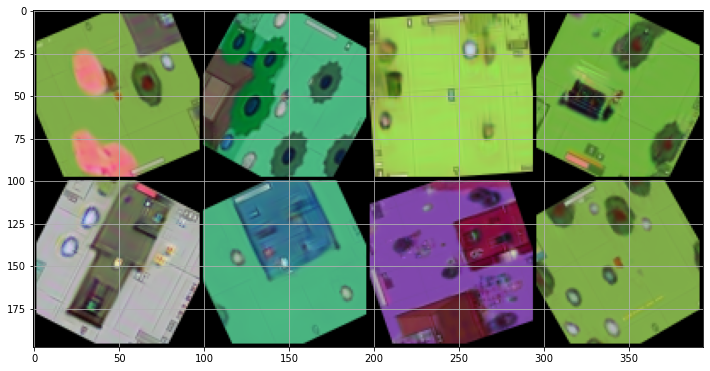

In [10]:
params = {'EPOCHS': 30,
          'DEVICE': 'cuda:0',
          'BATCH': 8}

train_data = Stone_Dataset(df_train.values, True)
train_dataloader = DataLoader(train_data, batch_size=params['BATCH'], shuffle=True)
test_data = Stone_Dataset(df_val.values, False)
test_dataloader = DataLoader(test_data, batch_size=params['BATCH'], shuffle=True)

img, target = iter(train_dataloader).next()
print(target)
plot_samples_on_epoch((img+1)/2)

In [11]:
model = StoneClassifier().to(params['DEVICE'])
model.load_state_dict(torch.load('laggg_stone_classifier_v1.pth'))
model = model.to(params['DEVICE'])

criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer=opt, step_size=10, gamma=0.1)

trainloss_ts = []
trainmetr_ts = []
valloss_ts = []
valmetr_ts = []
train_model(model, train_dataloader, test_dataloader,
            criterion, opt, scheduler, params)

1/30 lr: 0.001 | train_loss: 0.4453 | val_loss: 0.4548 | train_metr: 0.7445 | val_metr: 0.8043
2/30 lr: 0.001 | train_loss: 0.4465 | val_loss: 0.448 | train_metr: 0.7421 | val_metr: 0.8361
3/30 lr: 0.001 | train_loss: 0.4453 | val_loss: 0.455 | train_metr: 0.7456 | val_metr: 0.8275
4/30 lr: 0.001 | train_loss: 0.4455 | val_loss: 0.4649 | train_metr: 0.742 | val_metr: 0.8396
5/30 lr: 0.001 | train_loss: 0.4526 | val_loss: 0.4447 | train_metr: 0.7158 | val_metr: 0.8338
6/30 lr: 0.001 | train_loss: 0.4374 | val_loss: 0.437 | train_metr: 0.7588 | val_metr: 0.8368
7/30 lr: 0.001 | train_loss: 0.4423 | val_loss: 0.4444 | train_metr: 0.7516 | val_metr: 0.8374
8/30 lr: 0.001 | train_loss: 0.439 | val_loss: 0.4516 | train_metr: 0.7624 | val_metr: 0.8274
9/30 lr: 0.001 | train_loss: 0.4368 | val_loss: 0.4417 | train_metr: 0.7546 | val_metr: 0.8068
10/30 lr: 0.001 | train_loss: 0.4359 | val_loss: 0.4434 | train_metr: 0.7518 | val_metr: 0.8396
11/30 lr: 0.0001 | train_loss: 0.4347 | val_loss: 0.44

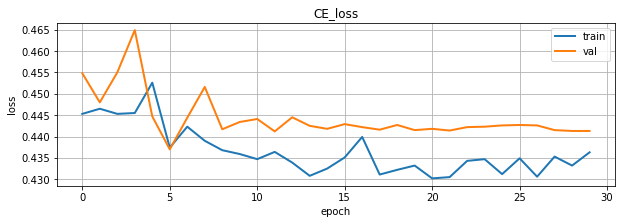

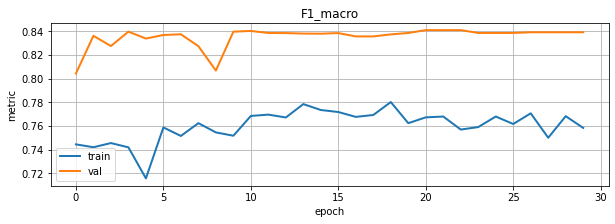

In [12]:
plt.figure(figsize=(10,3));
plt.plot(trainloss_ts, label='train', linewidth=2)
plt.plot(valloss_ts, label='val', linewidth=2)
plt.title('CE_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show();

plt.figure(figsize=(10,3));
plt.plot(trainmetr_ts, label='train', linewidth=2)
plt.plot(valmetr_ts, label='val', linewidth=2)
plt.title('F1_macro')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show();

## Validate

In [14]:
params = {'EPOCHS': 30,
          'DEVICE': 'cuda:0',
          'BATCH': 8}

def validate(model, tresh=0.5, confm_normalize=True):
    y_pred = []
    y_true = []
    model.eval()
    reward_frame_transform = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(24)])
    for x in enumerate(test_dataloader):
        img = x[1][0].to(params['DEVICE'])
        target = x[1][1]
        y_true.extend(target.tolist())
        img = reward_frame_transform(img)
        with torch.no_grad():
            r = model(img)[:,1]
        r = (r>tresh).int().detach().cpu().tolist()
        y_pred.extend(r)
    val_acc = round(accuracy_score(y_true, y_pred),4)
    val_f1 = round(f1_score(y_true, y_pred, average='macro'),4)
    print('f1 macro:', val_f1)
    plot_confusion_matrix(y_true, y_pred, range(2), normalize=confm_normalize)

In [17]:
model2 = StoneClassifier()
model2.load_state_dict(torch.load('dfomin_stone_classifier_v2.pth'))
model2 = model2.to(params['DEVICE'])

model3 = StoneClassifier()
model3.load_state_dict(torch.load('laggg_stone_classifier_v1.pth'))
model3 = model3.to(params['DEVICE'])

model1 = StoneClassifier()
model1.load_state_dict(torch.load('laggg_stone_classifier_v2.pth'))
model1 = model1.to(params['DEVICE'])

f1 macro: 0.8442


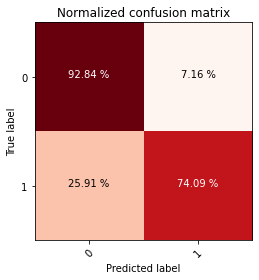

f1 macro: 0.8427


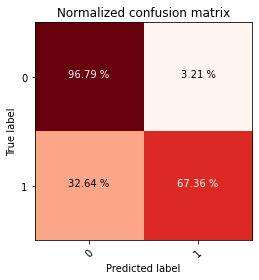

f1 macro: 0.8409


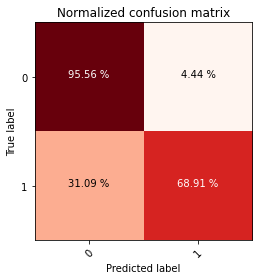

In [18]:
validate(model2, tresh=0.95)
validate(model3, tresh=0.95)
validate(model1, tresh=0.95)